<a href="https://colab.research.google.com/github/PattanAsifKhan/Microsoft_Hack_2024/blob/main/Hackathon_Microsoft_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: Read data from customer_support_data.csv.zip

import pandas as pd

# Assuming the file is in your current working directory or you provide the correct path
df = pd.read_csv('sample_data/Customer_support_data.csv.zip', compression='zip')

df.columns = df.columns.str.replace(' ', '_')


In [2]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['#missing'] = df.isnull().sum().values
    summry['Duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['avg'] = desc['mean'].values
    summry['std dev'] = desc['std'].values
    summry['top value'] = desc['top'].values
    summry['Freq'] = desc['freq'].values

    return summry


In [3]:
def calculate_resolved_time(row):
    if pd.notnull(row['Issue_reported_at']) and pd.notnull(row['issue_responded']):
        return abs((pd.to_datetime(row['issue_responded']) - pd.to_datetime(row['Issue_reported_at'])).total_seconds() / 60)
    else:
      return None
df['connected_handling_time'] = df.apply(calculate_resolved_time, axis=1)
avg_resolved_time = df['connected_handling_time'].mean()
df['connected_handling_time'].fillna(avg_resolved_time, inplace=True)
df.head()

<ipython-input-3-85199edc14a9>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return abs((pd.to_datetime(row['issue_responded']) - pd.to_datetime(row['Issue_reported_at'])).total_seconds() / 60)
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unique_id,channel_name,category,Sub-category,Customer_Remarks,Order_id,order_date_time,Issue_reported_at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure_Bucket,Agent_Shift,CSAT_Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,34.0,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,2.0,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,22.0,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,20.0,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,2.0,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


In [4]:
# Step 1: Calculate average connected handling time in hours
agent_performance_df = df.groupby(['Agent_name', 'Product_category'])['connected_handling_time'].mean() / 3600

# Step 2: Reset index to convert Series back to DataFrame and rename columns
agent_performance_df = agent_performance_df.reset_index()
agent_performance_df.columns = ['Agent Name', 'Category', 'Avg_Time_Spent_On_Category']

# Step 3: Rank the agents based on average time spent on each category
agent_performance_df['Rank'] = agent_performance_df.groupby('Category')['Avg_Time_Spent_On_Category'].rank(method='min')

# Step 4: Sort the DataFrame by Category and Rank
agent_performance_df = agent_performance_df.sort_values(by=['Category', 'Rank'], ascending=[True, False])

min_rank = agent_performance_df.groupby('Category')['Rank'].max().reset_index()

# Step 2: Merge to get the top-performing agents
top_performers = agent_performance_df.merge(min_rank, on=['Category', 'Rank'], how='inner')

top_performers.head()

,Agent Name,Category,Avg_Time_Spent_On_Category,Rank
0,Alyssa Mcpherson,Affiliates,48.799444,157.0
1,Michael Dunlap,Books & General merchandise,81.782222,1113.0
2,James Lopez,Electronics,81.801389,1206.0
3,Veronica Choi,Furniture,81.846944,377.0
4,Mark Black,GiftCard,81.607500,25.0


In [5]:
import numpy as np
from scipy.stats import norm

# Function to calculate likelihood of an agent resolving quicker
def calculate_agent_probability(agent_name, category, time_limit, df):
    # Get the average resolution time for the agent and category
    agent_data = df[(df['Agent Name'] == agent_name) & (df['Category'] == category)]
    if agent_data.empty:
        return None  # No historical data for this agent in this category

    avg_time = agent_data['Avg_Time_Spent_On_Category'].values[0]
    std_dev = np.std(df['Avg_Time_Spent_On_Category'])  # Using global std dev for simplicity

    # Prior probability (e.g., a uniform distribution for each agent)
    prior = 1 / df['Agent Name'].nunique()

    # Likelihood: P(data | resolve quicker) ~ N(avg_time, std_dev)
    likelihood = norm.cdf(time_limit, loc=avg_time, scale=std_dev)

    # Posterior probability (simplified, ignoring normalization for now)
    posterior = likelihood * prior * 100
    if posterior>0:
      return posterior
    return 0.0

agents = agent_performance_df['Agent Name'].unique()
category = 'Books & General merchandise'
time_limit = 10  # Minutes

# Calculate probabilities for all agents
probabilities = {agent: calculate_agent_probability(agent, category, time_limit, agent_performance_df) for agent in agents}

for i in probabilities:
  if probabilities[i] is None:
    probabilities[i] = 0.0

sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

# Print ranked agents
for agent, prob in sorted_probabilities:
    print(f"Agent: {agent}, Probability of Resolving Quicker: {prob}")


Agent: Linda Murray, Probability of Resolving Quicker: 0.06410989744069083
Agent: Sarah Keller, Probability of Resolving Quicker: 0.06410989744069083
Agent: Paula Brooks, Probability of Resolving Quicker: 0.06410989744069083
Agent: Alan Davies, Probability of Resolving Quicker: 0.06410989744069083
Agent: Alexandra Reynolds, Probability of Resolving Quicker: 0.06410989744069083
Agent: Angela Brown, Probability of Resolving Quicker: 0.06410989744069083
Agent: Crystal Walsh, Probability of Resolving Quicker: 0.06410989744069083
Agent: Kimberly Miller, Probability of Resolving Quicker: 0.06410989744069083
Agent: Michael Perez, Probability of Resolving Quicker: 0.06410989744069083
Agent: Peter Lawrence, Probability of Resolving Quicker: 0.06410989744069083
Agent: Robert Lopez, Probability of Resolving Quicker: 0.06410989744069083
Agent: Ruben Horton, Probability of Resolving Quicker: 0.06410989744069083
Agent: Teresa George, Probability of Resolving Quicker: 0.06410989744069083
Agent: Amy M

In [6]:
def simulate_average_resolution_time(agent_name, category, df, num_simulations=10000):
    # Get the resolution times for the agent and category
    agent_data = df[(df['Agent Name'] == agent_name) & (df['Category'] == category)]

    if agent_data.empty:
        return None  # No historical data for this agent in this category

    # Use the 'Avg_Time_Spent_On_Category' for realistic simulation
    resolution_times = agent_data['Avg_Time_Spent_On_Category'].values

    # Generate simulated resolution times by sampling from historical resolution times
    simulated_times = np.random.choice(resolution_times, size=num_simulations, replace=True)

    # Calculate the average resolution time from simulations
    avg_simulated_time = np.mean(simulated_times)

    return avg_simulated_time

agents = agent_performance_df['Agent Name'].unique()
category = 'Books & General merchandise'

# Calculate average resolution times for all agents using Monte Carlo simulation
avg_resolution_times = {agent: simulate_average_resolution_time(agent, category, agent_performance_df) for agent in agents}

# Remove None values
avg_resolution_times = {agent: avg_time for agent, avg_time in avg_resolution_times.items() if avg_time is not None}

# Calculate how many minutes quicker each agent is compared to others
quicker_comparisons = {}
for agent, avg_time in avg_resolution_times.items():
    quicker_comparisons[agent] = {other_agent: round(avg_time - other_avg_time, 2)
                                   for other_agent, other_avg_time in avg_resolution_times.items() if agent != other_agent}

# Print the comparisons
print("Minutes Quicker Comparison:")
minutes_diffrence_between_agents = {}
for agent, comparisons in quicker_comparisons.items():
    for other_agent, minutes_quicker in comparisons.items():
        if minutes_quicker > 0:  # Only show if the agent is quicker
            minutes_diffrence_between_agents[agent] = []
            minutes_diffrence_between_agents[agent].append([other_agent, minutes_quicker])

categories = agent_performance_df['Category'].unique()

# Dictionary to hold the ordered agents for each category
ordered_agents_by_category = {}

# Calculate average resolution times and rank agents for each category
for category in categories:
    avg_resolution_times = {agent: simulate_average_resolution_time(agent, category, agent_performance_df) for agent in agent_performance_df['Agent Name'].unique()}

    # Remove None values
    avg_resolution_times = {agent: avg_time for agent, avg_time in avg_resolution_times.items() if avg_time is not None}

    # Create a sorted list of agents based on their average resolution times
    sorted_agents = sorted(avg_resolution_times.items(), key=lambda x: x[1], reverse=True)

    # Store the sorted agents in the dictionary
    ordered_agents_by_category[category] = sorted_agents

# Print the ordered agents for each category
print("Ordered Agents by Category:")
for category, agents in ordered_agents_by_category.items():
    print(f"\nCategory: {category}, {agents}")

Minutes Quicker Comparison:
Ordered Agents by Category:

Category: Affiliates, [('Alyssa Mcpherson', 48.79944444444446), ('David Warren', 46.82749999999999), ('Nicole Green', 46.65444444444446), ('Jennifer Day', 24.296111111111106), ('Paul Roach', 17.41513888888889), ('Linda Butler', 12.343055555555557), ('Kelly Martin', 12.305555555555552), ('Omar Odonnell', 12.246111111111107), ('Ryan Thompson', 12.196388888888887), ('Monica Edwards', 12.149027777777777), ('Ernest Harrington', 5.8826388888888905), ('John Gonzalez', 1.4770833333333333), ('Mark Cook', 1.2325000000000004), ('David Weaver', 0.7819444444444446), ('Stacey Stokes', 0.6980555555555555), ('Aaron Edwards', 0.6369444444444443), ('Tracy Weaver', 0.47027777777777763), ('Kelsey Richardson', 0.4425), ('Dominique Roberts', 0.4101388888888889), ('Brandy Johnson', 0.38444444444444437), ('Molly Lozano', 0.3161111111111111), ('Anna Miller', 0.31500000000000006), ('Kimberly Rogers', 0.31027777777777776), ('Theresa Brown', 0.2544444444444

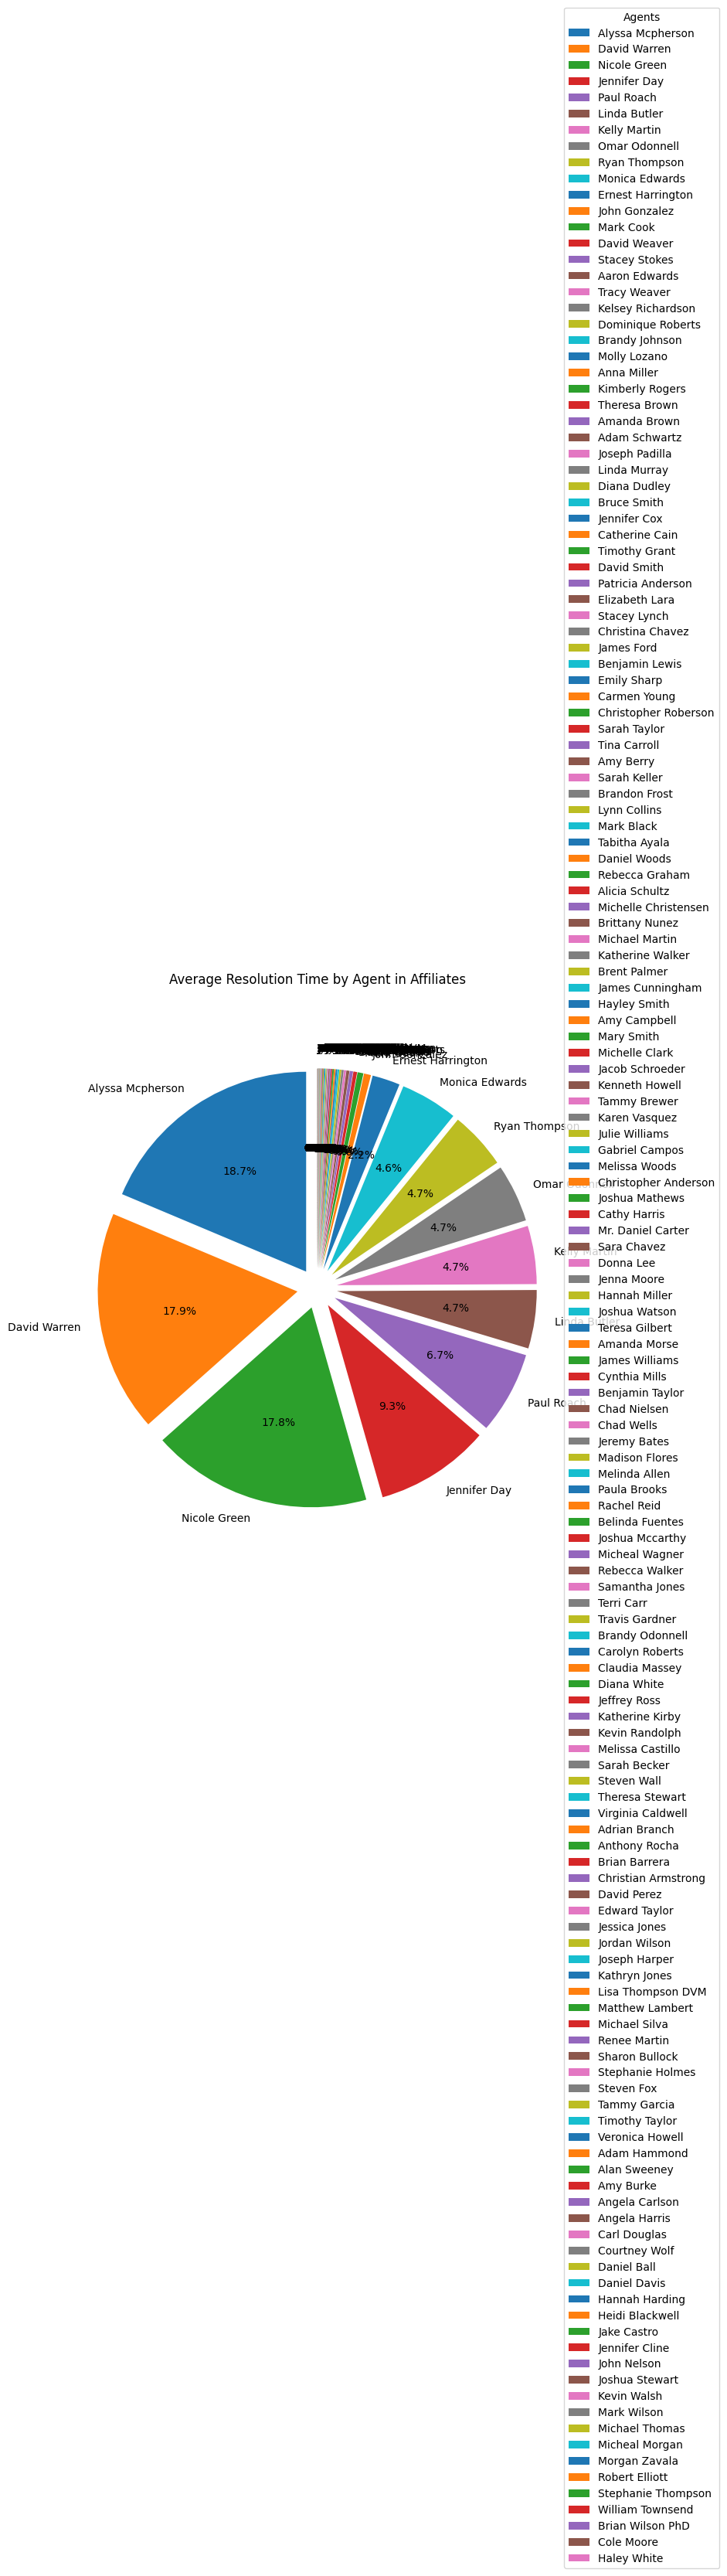

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for category, agents in ordered_agents_by_category.items():
    agent_names = [agent[0] for agent in agents]
    avg_times = [agent[1] for agent in agents]
    # Create a pie chart for average resolution times
    plt.figure(figsize=(10, 10))

    # Use explode to separate the slices for better visibility
    explode = [0.1] * len(agent_names)  # Offset all slices
    wedges, texts, autotexts = plt.pie(avg_times, labels=agent_names, autopct='%1.1f%%', startangle=90, explode=explode)

    plt.title(f'Average Resolution Time by Agent in {category}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

    # Place the legend outside the pie chart
    plt.legend(agent_names, title="Agents", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), ncol=1)
    plt.subplots_adjust(right=0.75)  # Adjust the plot to make space for the legend
    plt.show()
    break

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
from transformers import pipeline  # For sentiment analysis
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the dataset
data = pd.read_csv('sample_data/Customer_support_data.csv.zip', compression='zip')
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Preprocess the data
data['Customer_Remarks'] = data['Customer_Remarks'].astype(str)

# Check if CSAT_Score is numerical
data['CSAT_Score'] = pd.to_numeric(data['CSAT_Score'], errors='coerce')

# Initialize sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to get sentiment scores and labels
def get_sentiment(row):
    result = sentiment_pipeline(row['Customer_Remarks'])[0]
    return pd.Series([result['score'], result['label']])  # Returns score and label

# Apply sentiment analysis
data[['Sentiment_Score', 'Sentiment_Label']] = data.apply(get_sentiment, axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['Customer_Remarks'], data['CSAT_Score'], test_size=0.2, random_state=42)

# BERT Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

def encode_comments(comments):
    return tokenizer(comments.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

train_encodings = encode_comments(X_train)
test_encodings = encode_comments(X_test)

# Build the LSTM Model
def create_lstm_model():
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=128, input_length=max_length))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))  # Single output for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

lstm_model = create_lstm_model()
lstm_model.fit(train_encodings['input_ids'], y_train, epochs=1, batch_size=32)

# Evaluate the model
y_pred_lstm = lstm_model.predict(test_encodings['input_ids'])
print("LSTM Predictions (CSAT Scores):", y_pred_lstm)

# Calculate agent performance metrics based on CSAT scores
agent_performance_df = data.groupby('Agent_Name').agg({
    'CSAT_Score': 'mean',
}).reset_index()

print("Agent Performance Metrics:")
print(agent_performance_df)

# Print sentiment analysis results
print("\nSentiment Analysis Results:")
print(data[['Customer_Remarks', 'Sentiment_Score', 'Sentiment_Label']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Index(['Unique_id', 'channel_name', 'category', 'Sub-category',
       'Customer_Remarks', 'Order_id', 'order_date_time', 'Issue_reported_at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure_Bucket', 'Agent_Shift',
       'CSAT_Score'],
      dtype='object')


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
# Build the BERT Model
def create_bert_model():
    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_length,), dtype=tf.int32)

    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    cls_output = outputs[1]  # Get the CLS token output
    dense = layers.Dense(64, activation='relu')(cls_output)
    output = layers.Dense(1, activation='linear')(dense)  # Single output for regression

    model = models.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

bert_model = create_bert_model()
bert_model.fit([train_encodings['input_ids'], train_encodings['attention_mask']], y_train, epochs=1, batch_size=32)

# Evaluate the BERT model
y_pred_bert = bert_model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
print("BERT MAE Report:")
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred_bert.flatten())))